In this tutorial I will explain how to generate a Wikipedia article using LSTM and Recurrent neural network.

In a traditional neural network, we assume that all the inputs are independent of each other and that’s not the case in most applications. On the other hand, recurrent neural network perceive one step back in time, in other words, it keeps track of the dependencies within the sequence. Imagine you have a sentence like "Jack went to the party, he drank so much", a normal neural network won't be able to understand that Jack drank too much, however RNN would.

LSTM cells act on the signals they receive, and similar to the neural network’s nodes, they block or pass on information based on its strength and import, which they filter with their own sets of weights. Those weights, like the weights that modulate input and hidden states, are adjusted via the recurrent networks learning the process.

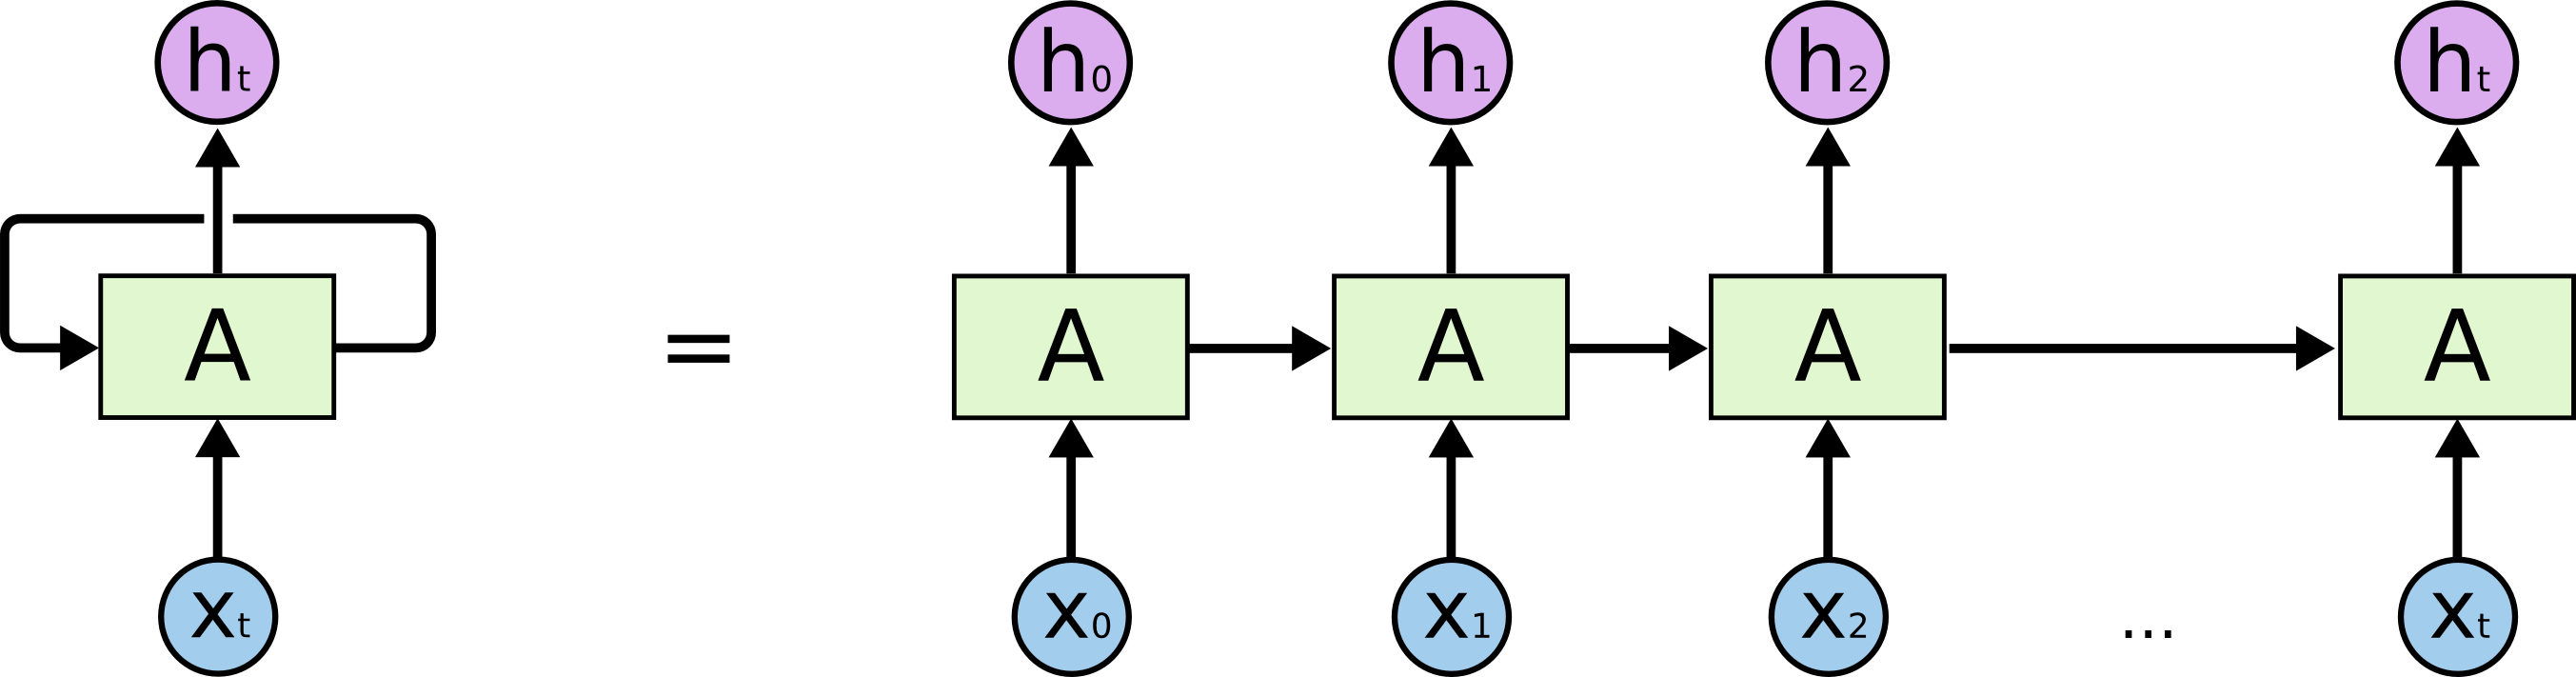

Let's start first by downloading our Dataset, for this project we will use Wikitext from MetaMind. Go to this link and download it https://metamind.io/research/the-wikitext-long-term-dependency-language-modeling-dataset/ 

In [7]:
#Import the dataset
text = open('wiki.test.raw',encoding="utf8").read()

len(text)

580441

In [8]:
text[0:2000]

' \n = Robert Boulter = \n \n Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He appeared o

Now after we got out data let's start explaining the approach that we will use to generate the text, We start by encoding each character into a one-hot encoding vector, then we feed our neural network a huge chunk of text and ask it to model the probability distribution of the next character in the sequence given a sequence of previous characters. This process will help us to generate new text one character at a time.

Andrej Karpathy explains the approach very well in his Blog (http://karpathy.github.io/2015/05/21/rnn-effectiveness/), he said "We see that in the first time step when the RNN saw the character “h” it assigned confidence of 2.2 to letter “e”, -3.0 to “l”, and 4.1 to “o”. Since in our training data (the string “hello”) the next correct character is “e”, we would like to increase its confidence (green) and decrease the confidence of all other letters (red). Similarly, we have the desired target character at every one of the 4-time steps that we’d like the network to assign a greater confidence to. If we were to feed the same inputs to the RNN after the parameter update we would find that the scores of the correct characters (e.g. “e” in the first time step) would be slightly higher (e.g. 2.3 instead of
2.2), and the scores of incorrect characters would be slightly lower. We then repeat this process over and over many times until the network converges and its predictions are eventually consistent with the training data in that correct characters are always predicted next.”

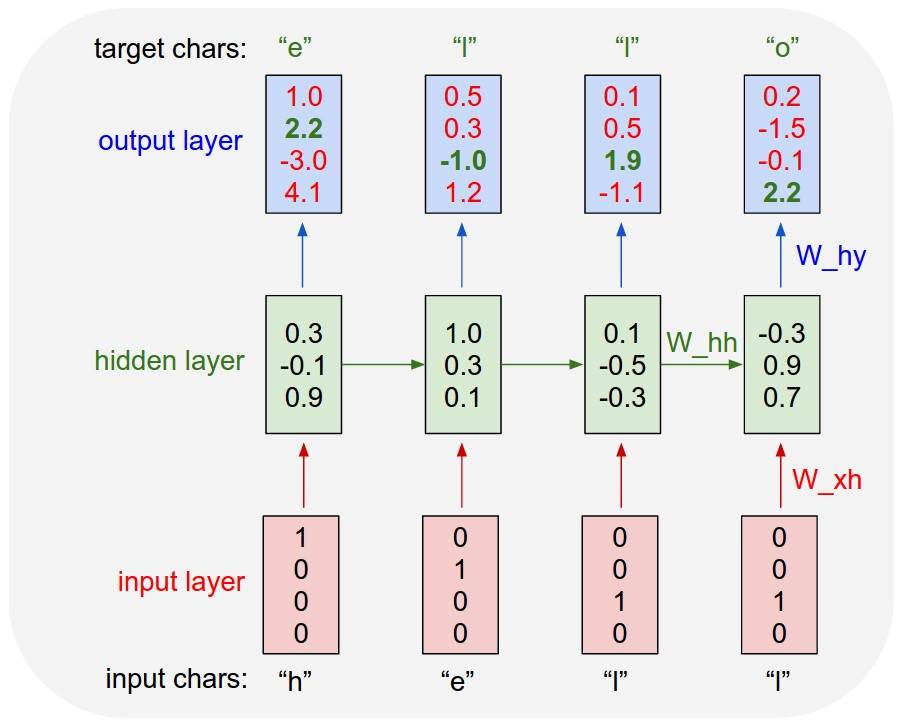

In [10]:
#Let's define the pre-requisite before we start building the network
#Find all the characters in the training set
letters = list(set(text))
letters

['ω',
 '’',
 'K',
 '贈',
 '&',
 'f',
 '4',
 '[',
 'ö',
 '衛',
 'p',
 '3',
 'ς',
 '©',
 'l',
 'Ω',
 '東',
 'É',
 'λ',
 ']',
 '+',
 '⁄',
 '5',
 'u',
 'Π',
 '−',
 'ü',
 'o',
 'ẩ',
 '2',
 '"',
 '士',
 '律',
 'é',
 'Á',
 '甫',
 'ǜ',
 '聖',
 'ñ',
 '9',
 '春',
 '處',
 'Y',
 'a',
 '1',
 'Z',
 '!',
 '-',
 '八',
 'ι',
 '(',
 'υ',
 'μ',
 'Q',
 'í',
 'k',
 'ν',
 'Ō',
 'ο',
 'ό',
 '?',
 '<',
 'B',
 '♯',
 '>',
 'U',
 'G',
 '.',
 'X',
 'ə',
 'w',
 '—',
 '°',
 '成',
 'ō',
 'ó',
 'S',
 'ã',
 's',
 'ǐ',
 'x',
 'è',
 '%',
 'N',
 'y',
 't',
 '^',
 ',',
 '大',
 'i',
 'τ',
 'D',
 '杜',
 'ī',
 'b',
 '£',
 'v',
 '史',
 '型',
 'R',
 '0',
 'L',
 'ä',
 '甲',
 '₱',
 ';',
 '勢',
 'T',
 '邵',
 '詩',
 'A',
 '‑',
 '戦',
 ')',
 'E',
 '#',
 ' ',
 'H',
 'P',
 '解',
 '‡',
 'n',
 'j',
 'έ',
 '傳',
 'ú',
 'á',
 'c',
 'ả',
 '6',
 'ě',
 '=',
 'r',
 '–',
 'M',
 '鉄',
 'e',
 'J',
 'g',
 '/',
 'V',
 'à',
 '集',
 'ê',
 'm',
 '8',
 'δ',
 '\n',
 'd',
 'C',
 '望',
 'ô',
 'W',
 'q',
 'æ',
 'σ',
 '$',
 '伊',
 'ε',
 'h',
 '@',
 '艦',
 ':',
 'π',
 "'",
 'F',
 'ū

In [11]:
len(letters)

174

In [28]:
import numpy as np
#Given a probability of each character, return a likely character, one-hot encoded
#our prediction will give us an array of probabilities of each character
#we'll pick the most likely and one-hot encode it
def sample(prediction):
    r = random.uniform(0,1)
    s = 0
    char_id = len(prediction) - 1
    for i in range(len(prediction)):
        if s >= r:
            char_id = i
            break
    number_of_letters = len(letters)

    char_one_hot = np.zeros(shape=[number_of_letters])
    char_one_hot[char_id] = 1.0
    return char_one_hot

In [29]:
#dictionary that maps each character to a number and vice versa

char2id = dict((c, i) for i, c in enumerate(letters))
id2char = dict((i, c) for i, c in enumerate(letters))

In [31]:
#vectorize our data to feed it into model
char_size = len(letters)
len_per_section = 174
skip = 2
sections = []
next_chars = []
#fill sections list with chunks of text, every 2 characters create a new 174 character long section
#because we are generating it at a character level
for i in range(0, int(len(text)) - len_per_section, skip):
    sections.append(text[i: i + len_per_section])
    next_chars.append(text[i + len_per_section])

#Vectorize input and output
#matrix of section length by num of characters
X = np.zeros((len(sections), char_size, char_size), dtype=int)
#label column for all the character id's, still zero
y = np.zeros((len(sections), char_size))

#for each char in each section, convert each char to an ID
#for each section convert the labels to ids 
for i, section in enumerate(sections):
    for j, char in enumerate(section):
        X[i, j, char2id[char]] = 1
    y[i, char2id[next_chars[i]]] = 1

Now we are finally ready to build our model, the LSTM needs four gates: Input, Forget, Output, Memory
and each gate needs an Input, Output, and Bias

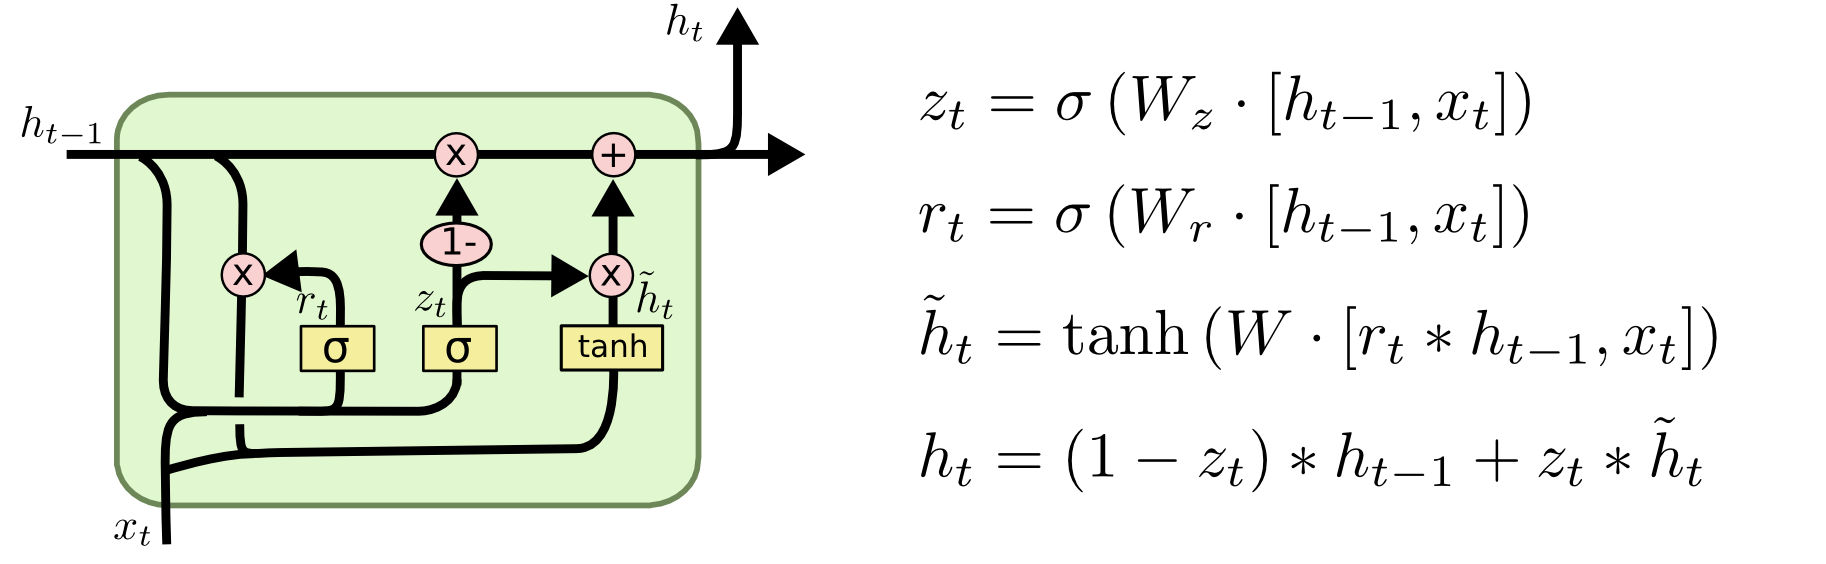

In [15]:
import tensorflow as tf

batch_size = 512
max_steps = 100
log_every = 100
save_every = 6000

hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    global_step = tf.Variable(0)
    
    data = tf.placeholder(tf.float32, [batch_size, len_per_section, char_size])
    labels = tf.placeholder(tf.float32, [batch_size, char_size])
     
    w_ii = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_io = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_i = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Forget gate: weights for input, weights for previous output, and bias
    w_fi = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_fo = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_f = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Output gate: weights for input, weights for previous output, and bias
    w_oi = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_oo = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_o = tf.Variable(tf.zeros([1, hidden_nodes]))
    #Memory cell: weights for input, weights for previous output, and bias
    w_ci = tf.Variable(tf.truncated_normal([char_size, hidden_nodes], -0.1, 0.1))
    w_co = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], -0.1, 0.1))
    b_c = tf.Variable(tf.zeros([1, hidden_nodes]))
    
    
    # given input, output, external state, it will return output and state
    
    #Since, we have two kinds of states - the internal state
    #and the (exposed) external state, and since we need both of 
    #them for the subsequent sequential operations, we combine them 
    #into a tensor at each step, and pass them as input to the next 
    #step. This tensor is unpacked into st_1 and ct_1 at the beginning of each step.
    
    def lstm(i, o, state):
        
        #(input * input weights) + (output * weights for previous output) + bias
        input_gate = tf.sigmoid(tf.matmul(i, w_ii) + tf.matmul(o, w_io) + b_i)
        #(input * forget weights) + (output * weights for previous output) + bias
        forget_gate = tf.sigmoid(tf.matmul(i, w_fi) + tf.matmul(o, w_fo) + b_f)
        #(input * output weights) + (output * weights for previous output) + bias
        output_gate = tf.sigmoid(tf.matmul(i, w_oi) + tf.matmul(o, w_oo) + b_o)
        #(input * internal state weights) + (output * weights for previous output) + bias
        memory_cell = tf.sigmoid(tf.matmul(i, w_ci) + tf.matmul(o, w_co) + b_c)
        
        state = forget_gate * state + input_gate * memory_cell
        output = output_gate * tf.tanh(state)
        return output, state
    


    output = tf.zeros([batch_size, hidden_nodes])
    state = tf.zeros([batch_size, hidden_nodes])

    #for each input set
    for i in range(len_per_section):
        #calculate state and output from LSTM
        output, state = lstm(data[:, i, :], output, state)
        if i == 0:
            #store initial output and labels
            outputs_all_i = output
            labels_all_i = data[:, i+1, :]
        #for each new set, concat outputs and labels
        elif i != len_per_section - 1:
            outputs_all_i = tf.concat([outputs_all_i, output], 0)
            labels_all_i = tf.concat([labels_all_i, data[:, i+1, :]], 0)
        else:
            outputs_all_i = tf.concat([outputs_all_i, output], 0)
            labels_all_i = tf.concat([labels_all_i, labels], 0)
        
    w = tf.Variable(tf.truncated_normal([hidden_nodes, char_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([char_size]))

    logits = tf.matmul(outputs_all_i, w) + b
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_all_i))

    optimizer = tf.train.GradientDescentOptimizer(10.).minimize(loss, global_step=global_step)
    

In [21]:
#timew to train the model, initialize a session with a graph
with tf.Session(graph=graph) as sess:
    #standard init step
    tf.global_variables_initializer().run()
    offset = 0
    #Create a saver to save the model
    saver = tf.train.Saver()
    
    #for each training step
    # I used only 100 iteration because my laptop kept crashing
    for step in range(max_steps):
        
        #starts off as 0
        offset = offset % len(X)
        
        #calculate batch data and labels to feed model iteratively
        if offset <= (len(X) - batch_size):
            batch_data = X[offset: offset + batch_size]
            batch_labels = y[offset: offset + batch_size]
            offset += batch_size
        else:
            to_add = batch_size - (len(X) - offset)
            batch_data = np.concatenate((X[offset: len(X)], X[0: to_add]))
            batch_labels = np.concatenate((y[offset: len(X)], y[0: to_add]))
            offset = to_add
        _, training_loss = sess.run([optimizer, loss], feed_dict={data: batch_data, labels: batch_labels})
        
        if step % 10 == 0:
            print('training loss at step %d: %.2f' % (step, training_loss))

            if step % save_every == 0:
                saver.save(sess,  "./trained_variables.ckpt", global_step=step)

training loss at step 0: 5.14
training loss at step 10: 6.58
training loss at step 20: 5.76
training loss at step 30: 3.71
training loss at step 40: 3.59
training loss at step 50: 3.68
training loss at step 60: 3.32
training loss at step 70: 3.53
training loss at step 80: 3.43
training loss at step 90: 3.21


In [32]:
test_start = 'I plan to make the world a better place'

with tf.Session(graph=graph) as sess:
    #init graph, load model
    tf.global_variables_initializer().run()
    model = tf.train.latest_checkpoint("./trained_variables.ckpt")
    saver = tf.train.Saver()
    saver.restore(sess, model)

    #set input variable to generate chars from
    reset_test_state.run() 
    test_generated = test_start

    #for every char in the input sentennce
    for i in range(len(test_start) - 1):
        #initialize an empty char store
        test_X = np.zeros((1, char_size))
        #store it in id from
        test_X[0, char2id[test_start[i]]] = 1.
        #feed it to model, test_prediction is the output value
        _ = sess.run(test_prediction, feed_dict={test_data: test_X})

    
    #where we store encoded char predictions
    test_X = np.zeros((1, char_size))
    test_X[0, char2id[test_start[-1]]] = 1.

    #lets generate 200 characters
    for i in range(200):
        #get each prediction probability
        prediction = test_prediction.eval({test_data: test_X})[0]
        #one hot encode it
        next_char_one_hot = sample(prediction)
        #get the indices of the max values (highest probability)  and convert to char
        next_char = id2char[np.argmax(next_char_one_hot)]
        #add each char to the output text iteratively
        test_generated += next_char
        test_X = next_char_one_hot.reshape((1, char_size))

    print(test_generated)

I plan to make the world a better place afewdsa daieman dsidew, dasd’ds ‘xcvbgf; mnbvot ,.mtegdfklgf gdsfgjlskrg gdioj gf j orgjdsk kldjsk iosjdf;klwenk m,nwer-pdf mmneahnfsd [opweqroijsfd epo sdfpok.


So the result above is really bad which was expected given the number of the iterations, however I ran the code again but with 300 iterations and I got the following result:

I plan to make the world a better place dalr oidjfsom sindmfkl njm] dds. on bu,tsa kalsdlnie planekd zpot, the[ kiokmsdf ife jiofei ;lsdmeie wadm eat fioalpok popofsmv; dfs in the pd[fsmkd ajdskm nf"d

I would recommend runnign this on the cloud (AWS) which will give you a better result, go to this blog to check better result (http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

Thank you !!